In [2]:
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
from collections import defaultdict
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

from grid import Grid
from agent import Agent
from value_iteration import get_true_Qs
import neural_net

The following test grids are the same as those presented to humans in behavioral experiments. Each grid is defined by its initial starting configuration. The first digit of the grid number identifies the grid type:   
100s - push  
200s - switch   
300s - switch control  
400s - push control  

In [3]:
TEST_GRIDS = {}
with open('/Users/hartleylabadmin/code/HartleyLab/dual_rl_final/web_experiments/training_experiment/test_data.json') as json_file:
    grids = json.load(json_file)
    for gridnum, grid in grids.items():
        python_grid = {key: tuple(value) for key, value in grid.items() if key!="best_reward"}
        python_grid['best_reward'] = grid['best_reward']
        python_grid['num1'] = 1
        python_grid['num2'] = 2
        TEST_GRIDS[int(gridnum)] = python_grid

The following example shows how to use the Agent to solve a given test grid. 

In [4]:
agent=Agent()
grid = Grid(init_pos=TEST_GRIDS[103])

# Running dual model with 10000 monte-carlo iterations on test grid
Q = agent.mc_first_visit_control(grid, iters=10000, nn_init=True)
r = agent.run_final_policy(grid, Q,nn_init=True,display=True)

neural net loaded
[['2' '_' '_' '_' '<']
 ['_' '1' '_' '_' '_']
 ['_' '_' '_' 'a' '_']
 ['◉' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'S']]
   ----------------

(-1, 0)
[['2' '_' '_' '<' '_']
 ['_' '1' '_' '_' '_']
 ['◉' '_' '_' 'a' '_']
 ['b' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'S']]
   ----------------

(0, 1)
[['2' '_' '<' '_' '_']
 ['_' '1' '_' '_' '_']
 ['_' '◉' '_' 'a' '_']
 ['b' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'S']]
   ----------------

(-1, 0)
[['2' 'x' '_' '_' '_']
 ['_' '◉' '_' '_' '_']
 ['_' '_' '_' 'a' '_']
 ['b' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'S']]
   ----------------

(0, -1)
[['2' 'x' '_' '_' '_']
 ['◉' '_' '_' '_' '_']
 ['_' '_' '_' 'a' '_']
 ['b' '_' '_' '_' '_']
 ['_' '_' '_' '_' 'S']]
   ----------------

(-1, 0)
-1


We probe the models defined in `agent.py` by presenting the grids defined in `TEST_GRIDS` and recording the reward achieved for a given number of monte-carlo rollouts (iterations). Because the results can depend on what actions were randomly explored for small iteration numbers, we repeat each (grid, iteration) pair to get more reliable, averaged results.

Specifically, we compare the dual-model (with Q-values initialized by neural network predictions) to the classic monte-carlo model

In [5]:
ITERS = [0,50,100,150,200,250]
REPEATS = 10 #number of times to redo the iteration for consistency

agent = Agent()
dual_scores = defaultdict(list) # maps gridnum to array of dual-model scores (averaged) for all iteration numbers in ITERS
mc_scores = defaultdict(list) # maps gridnum to array of monte-carlo scores (averaged) for all iteration numbers in ITERS
for i in ITERS:
    print(i)
    for gridnum, grid in TEST_GRIDS.items():
        best_reward = grid['best_reward']
        dual_score = 0
        mc_score = 0
        for j in range(REPEATS):
            testgrid = Grid(init_pos=grid)
            Q = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=True)
            reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=True, display=False)
            dual_score += reward - best_reward 
            
            testgrid = Grid(init_pos=grid)
            Q = agent.mc_first_visit_control(testgrid.copy(), iters=i, nn_init=False)
            reward = agent.run_final_policy(testgrid.copy(), Q, nn_init=False, display=False)
            mc_score += reward - best_reward 
        dual_avg = dual_score/REPEATS
        mc_avg = mc_score/REPEATS
        dual_scores[gridnum].append(dual_avg)
        mc_scores[gridnum].append(mc_avg)


0
neural net loaded
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250
0
50
100
150
200
250


In [ ]:
# Collapses dual_scores and mc_scores by grid type (push-sacrifice, switch-sacrifice, push-get, switch-save)

dual_type_dict = defaultdict(list)  
mc_type_dict = defaultdict(list)

for grid in TEST_GRIDS.keys():
    if grid not in [401,405,204,208]:
        dual_type_dict[grid//100*100].append(dual_scores[grid])
        mc_type_dict[grid//100*100].append(mc_scores[grid])

for grid_type in dual_type_dict.keys():
    scores = np.array(dual_type_dict[grid_type])
    size = scores.shape[0]
    dual_type_dict[grid_type] = np.sum(scores,axis=0)/size
    
    scores = np.array(mc_type_dict[grid_type])
    mc_type_dict[grid_type] = np.sum(scores,axis=0)/size

In [ ]:
# Graphs impact of iterations on MC model performance for each grid type 

plt.plot(ITERS, mc_type_dict[100], label='Push', color="#FF3B4B", linewidth=4)
plt.plot(ITERS, mc_type_dict[200], label='Switch', color="#81CC18", linewidth=4)
plt.plot(ITERS, mc_type_dict[300], label='Switch Control', color="#464D77")
plt.plot(ITERS, mc_type_dict[400],label='Push Control', color="#36827F")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Standardized Score")
plt.title("FVMC performance on all test grids")
plt.show()

NameError: name 'plt' is not defined

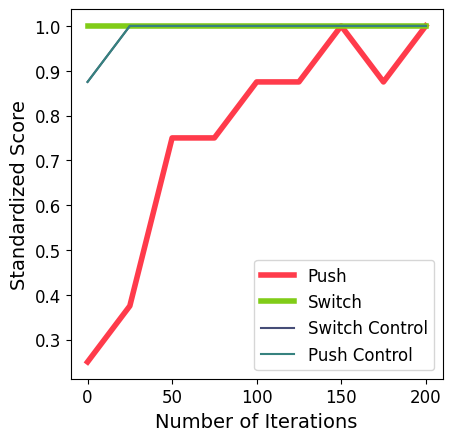

In [ ]:
# Graphs impact of iterations on dual model performance for each grid type 
w, h = figaspect(1)
fig, ax = plt.subplots(figsize=(w,h))

# Scaled +1 so values range from 0 to 1 matching behavioral data
plt.plot(ITERS, dual_type_dict[100]+1, label='Push', color="#FF3B4B", linewidth=4)
plt.plot(ITERS, dual_type_dict[200]+1, label='Switch', color="#81CC18", linewidth=4)
plt.plot(ITERS, dual_type_dict[300]+1, label='Switch Control', color="#464D77")
plt.plot(ITERS, dual_type_dict[400]+1, label='Push Control', color="#36827F")
plt.legend()
plt.xlabel("Number of Iterations", fontsize=14)
plt.ylabel("Standardized Score", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

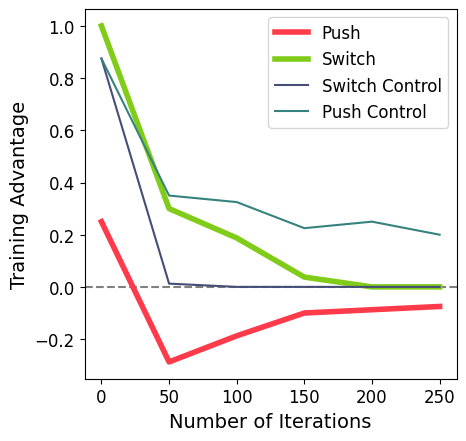

In [8]:
# Graphs difference between dual model and monte-carlo model for each grid type and varying iterations

grid_score_diff = defaultdict(list)

for grid in TEST_GRIDS.keys():
    difference = []
    zip_obj = zip(dual_scores[grid], mc_scores[grid])
    for dual_score, mc_score in zip_obj:
        difference.append(dual_score - mc_score)
    grid_score_diff[grid//100*100].append(difference)
     
for grid_type,diff in grid_score_diff.items():
    diff = np.array(diff)
    size = diff.shape[0]
    grid_score_diff[grid_type] = np.sum(diff,axis=0)/size
        
w, h = figaspect(1)
fig, ax = plt.subplots(figsize=(w,h))
plt.axhline(y=0, color='grey', linestyle='--')
plt.plot(ITERS, grid_score_diff[100], label='Push', color="#FF3B4B", linewidth=4)
plt.plot(ITERS, grid_score_diff[200], label='Switch', color="#81CC18", linewidth=4)
plt.plot(ITERS, grid_score_diff[300], label='Switch Control', color="#464D77")
plt.plot(ITERS, grid_score_diff[400], label='Push Control', color="#36827F")
plt.legend()
plt.xlabel("Number of Iterations", fontsize=14)
plt.ylabel("Training Advantage", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

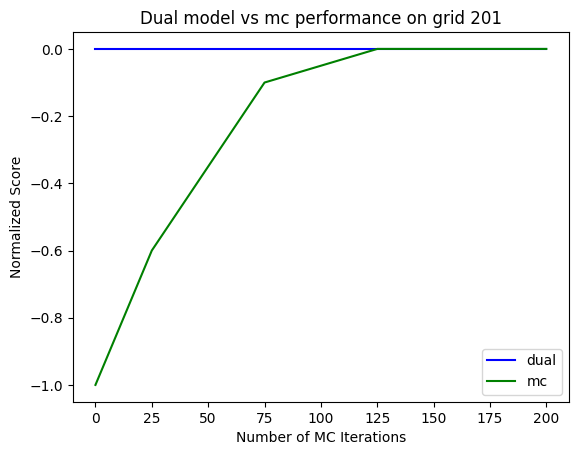

In [ ]:
# Graph difference between dual model and monte-carlo moodel for for a given test grid (to explore finer grained differences)

def graph_one(num, dual_scores, mc_scores):
    plt.plot(ITERS, dual_scores[num], label='dual', color="blue")
    plt.plot(ITERS, mc_scores[num], label='mc', color="green")
    plt.legend()
    plt.xlabel("Number of MC Iterations")
    plt.ylabel("Normalized Score")
    plt.title("Dual model vs mc performance on grid " + str(num))
    plt.show()

graph_one(201,dual_scores,mc_scores)
#101, 107

In [ ]:
# Comparing CNN predictions to ground truth values for test grids of interest

def label(x):
    if x < 100: return "filler"
    if 100 < x < 200: return "Push"
    if 200 < x < 300: return "Switch"
    if 300 < x < 400: return "Switch Control"
    if 400 < x: return "Push Control"

net = neural_net.load()
lst = []
for gridnum, grid in TEST_GRIDS.items():
    if gridnum > 100:
        testgrid = Grid(init_pos=grid)
        # ground truth values for optimal grid state and action sequence
        s, a, r, is_action_of_interest = get_true_Qs(testgrid.copy(), get_is_action_of_interest=True)
        for step in range(5):
            NN_output = neural_net.predict(net, s[step])[0]
            error = ((NN_output - a[step]) ** 2).mean(axis=0) # Mean squared error
            accuracy = np.argmax(NN_output) in np.argwhere(a[step] == np.amax(a[step])) # Best action matches one of optimal actions
            best_action_diff = np.average(NN_output[a[step] == np.amax(a[step])]) - np.amax(a[step])   # Raw difference between predicted Q values for best action
            lst.append([gridnum, step, error, accuracy, best_action_diff, is_action_of_interest[step]])
nn_performance = pd.DataFrame(lst, columns = ['gridnum', 'step', 'error', 'accuracy', 'Signed Error', 'action of interest'])
nn_performance['Grid Type'] = nn_performance['gridnum'].apply(label)

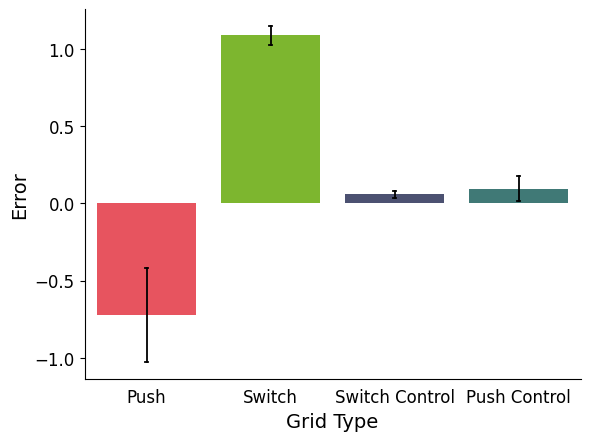

In [ ]:
# Graph difference between CNN predicted Q-values and true Q-values for push/switch action of interest

sns.reset_defaults()
color=['#FF3B4B', '#81CC18', '#464D77', '#36827F']
ax = sns.barplot(data=nn_performance[nn_performance['action of interest']==True], x="Grid Type", y="Signed Error", palette=color, capsize=0.03, errwidth=1.3, errcolor = 'black')
sns.despine()
plt.xlabel('Grid Type', fontsize=14)
plt.ylabel('Error', fontsize=14)
ax.tick_params(bottom=False, labelsize=12)
plt.show()

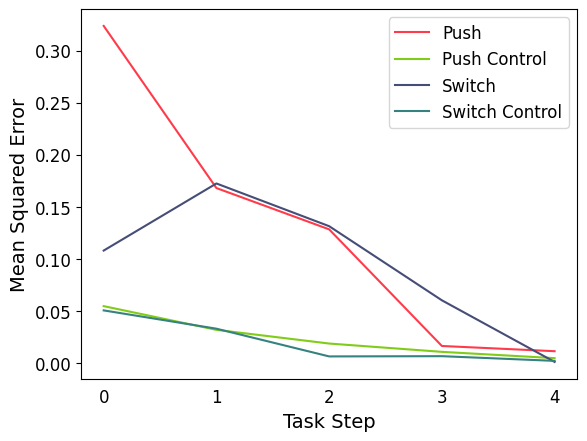

In [ ]:
# Graph mean squared error of CNN prediction for test grids averaged for each time step
df_mean = nn_performance.groupby(['step','Grid Type'] ,as_index=False)['error'].mean()
ax = sns.lineplot(data = df_mean, x='step', y="error", hue="Grid Type", palette=color)
plt.xlabel('Task Step', fontsize=14)
plt.ylabel('Mean Squared Error', fontsize=14)
plt.legend(fontsize=12)
ax.tick_params(bottom=False, labelsize=12)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

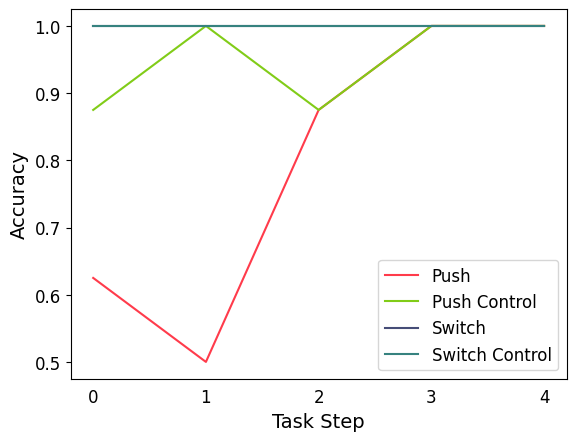

In [ ]:
# Graph accuracy of CNN prediction for test grids averaged for each time step
df_mean = nn_performance.groupby(['step','Grid Type'] ,as_index=False)['accuracy'].mean()
ax = sns.lineplot(data = df_mean, x='step', y="accuracy", hue="Grid Type", palette=color)
plt.xlabel('Task Step', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
ax.tick_params(bottom=False, labelsize=12)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()